<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Overview" data-toc-modified-id="Overview-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Overview</a></span></li><li><span><a href="#References" data-toc-modified-id="References-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>References</a></span></li><li><span><a href="#ArcGIS-Maps" data-toc-modified-id="ArcGIS-Maps-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>ArcGIS Maps</a></span></li><li><span><a href="#-Explore-Shape-Files-in-matplotlib-and-GeoPandas" data-toc-modified-id="-Explore-Shape-Files-in-matplotlib-and-GeoPandas-4"><span class="toc-item-num">4&nbsp;&nbsp;</span> Explore Shape Files in matplotlib and GeoPandas</a></span><ul class="toc-item"><li><span><a href="#-Import-Libraries" data-toc-modified-id="-Import-Libraries-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span> Import Libraries</a></span></li><li><span><a href="#-Read-Shape-Files" data-toc-modified-id="-Read-Shape-Files-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span> Read Shape Files</a></span></li><li><span><a href="#-Plot-with-matplotlib" data-toc-modified-id="-Plot-with-matplotlib-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span> Plot with matplotlib</a></span></li><li><span><a href="#-Print-acreage-data-for-each-time-frame" data-toc-modified-id="-Print-acreage-data-for-each-time-frame-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span> Print acreage data for each time frame</a></span></li><li><span><a href="#Plot-with-GeoPandas" data-toc-modified-id="Plot-with-GeoPandas-4.5"><span class="toc-item-num">4.5&nbsp;&nbsp;</span>Plot with GeoPandas</a></span></li></ul></li></ul></div>

<h2>Overview

This notebook summarizes the exploratory data visualization related to mapping the progression of the fire by time intervals and associating it with the the twitter and news data. Maps were made using maptplotlib and GeoPandas to explore the maps in this notebook. We also used ArcGIS.com to create some of the visuals. The twitter data was separated into files according to time interval to be imported as separate layer files in ArcGIS.

<h2>References

Camp fire data:<br>
__[US Geological Survey Fire Perimeter Data](https://rmgsc.cr.usgs.gov/outgoing/GeoMAC/2018_fire_data/California/Camp/)__<br>
__[CAL Fire Incident Data](https://arcgis.com)__<br>

Mapping tools tutorials and reference implementations:<br>
__[Mapping with Matplotlib, Pandas, GeoPandas and Basemap in Python](https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac)__<br>
__[ArcGIS.com](https://arcgis.com)__





<h2>ArcGIS Maps

This map shows the earliest documented permiter of the fire as of June 8, 2018. The heatmap circles depict the coordinate centers of areas under evacuation at this time.

<img src='../images/CampFireMapNov8.png' />


This map shows the perimeter and areas under evacuation orders four days later. At this time the fire was only 25% contained. 

<img src='../images/CampFireMapNov12.png' />



This map shows the fire November 20th. At this time it was 75% contained. The perimeter does not grow much after this point, but the fire was not 100% contained until November 25th. This map also shows the tweets, based on profile location of the twitter user. Locating the source of a tweet is challenging because, though location services are available, many users have this turned off. The tweet locations based on profile are not clustered around the fire location, but instead around population centers, primarily in California. The tweet volume and content proved to be more predictive, as is shown in modeling portion of this project.

<img src='../images/CampFireMapNov20Tweets.png' />

This map illustrates the location of fire-related tweets during the time range for the fire. Location information is derived from the profile data of the twitter user. It is difficult to get the location of where the user was at the time of the tweet because few users have that feature turned on. Deriving location based on the text was also inconclusive, because even when location data was included it was partial and contextual.

<img src='../images/CampFireMapWithTweets.png' />

<h2> Explore Shape Files in matplotlib and GeoPandas

Note: The code in this section was adapted from the Medium article noted above in the reference section. These are the same shape files used to render the the above images in ArgGIS.

<h3> Import Libraries

In [1]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import re


%matplotlib inline

In [2]:
import warnings;
warnings.simplefilter('ignore')

In [3]:
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

<h3> Read Shape Files

In [4]:
def read_shapefile(sf):
    #fetching the headings from the shape file
    fields = [x[0] for x in sf.fields][1:]
    #fetching the records from the shape file
    records = [list(i) for i in sf.records()]
    shps = [s.points for s in sf.shapes()]
    #converting shapefile data into pandas dataframe
    df = pd.DataFrame(columns=fields, data=records)
    #assigning the coordinates
    df = df.assign(coords=shps)
    return df

Shape files were downloaded from USGS, as noted above. Each downloaded zip file contains coordinate data for the perimeter of the fire at different stages, and records with additional information, such as acreage burned. This next block of code processes the files and stores them in several formats for further exploration. 

In [5]:
shape_file_list = [] #used to sort by date
shapes = [] #will be a 3-tuple with time interval, shape file reader, 
            #dataframe
shapes_df = pd.DataFrame() #to store each dataframe as imported

#walk the directory to get the names of all the downloaded shape files
for dirName, subdirList, fileList in os.walk('../tempdata') :
    for filename in fileList:
        if filename.startswith('ca_camp_') and filename.endswith('.shp'):
            shp_file_nm = os.path.join(dirName, filename)
            shape_file_list.append(shp_file_nm)

#remove duplicates from the list
shp_files = set(shape_file_list)  

#get a shapefile reader for each, read it into a dataframe
for i, shp_file_nm in enumerate(shp_files):
    sf = shp.Reader(shp_file_nm)
    df = read_shapefile(sf)
    #add the date_time to the df and create a 3-tuple of date, sf, df
    #to be used for exploration
    df['file_nm'] = shp_file_nm[20:33]
    shapes.append( (shp_file_nm[20:33],sf,df) ) 
    shapes_df = pd.concat([shapes_df,df])  

#sort by date so the plot loop renders maps in chronological order
sorted_by_date = sorted(shapes, key=lambda tup: tup[0])


<h3> Plot with matplotlib

This loop plots the perimeter of the fire at the different stages, along with the acreage burned.

In [6]:
def plot_shape(shape, id=0, s=None):
    sf = shape[1]
    timeframe = shape[0]
    acreage = shape[2]['GISACRES'][0]
    plt.figure()
    #plotting the graphical axes where map ploting will be done
    ax = plt.axes()
    ax.set_aspect('equal')
    #storing the id number to be worked upon
    shape_ex = sf.shape(id)
    #NP.ZERO initializes an array of rows and column with 0 in place of each elements 
    #an array will be generated where number of rows 
    #will be(len(shape_ex,point))and number of columns will be 1 and stored into the variable
    x_lon = np.zeros((len(shape_ex.points),1))
    #an array will be generated where number of rows will be(len(shape_ex,point))
    #and number of columns will be 1 and stored into the variable
    y_lat = np.zeros((len(shape_ex.points),1))
    for ip in range(len(shape_ex.points)):
        x_lon[ip] = shape_ex.points[ip][0]
        y_lat[ip] = shape_ex.points[ip][1]
    ax.fill(x_lon,y_lat, 'r')
        
    #plotting using the derived coordinated stored in array created by numpy
    plt.plot(x_lon,y_lat) 
    x0 = np.mean(x_lon)
    y0 = np.mean(y_lat)
    plt.text(x0, y0, s, fontsize=10)
    # use bbox (bounding box) to set plot limits
    plt.xlim(shape_ex.bbox[0],shape_ex.bbox[2])
    plt.title(f'Timeframe: {timeframe}, Acres: {acreage}')
    return x0, y0


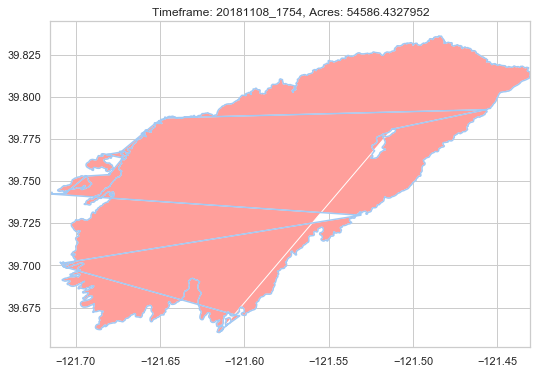

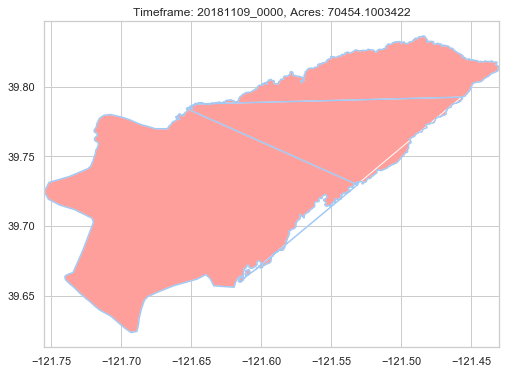

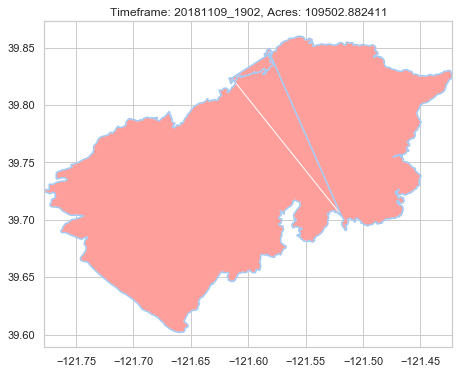

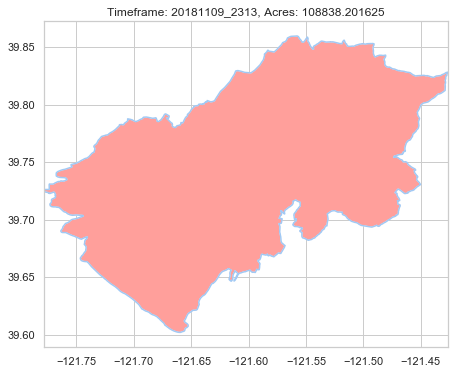

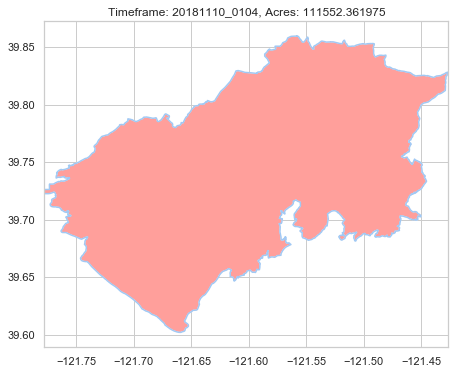

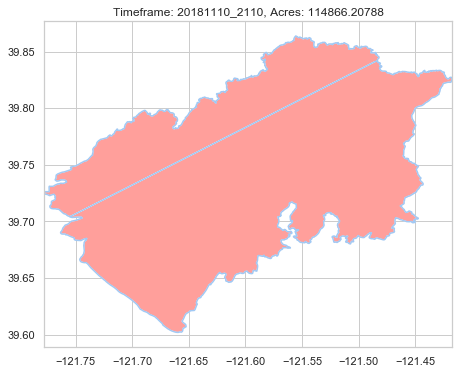

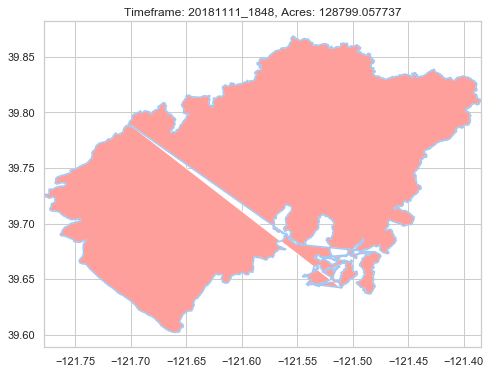

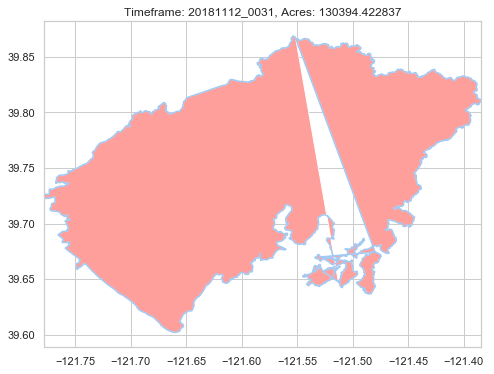

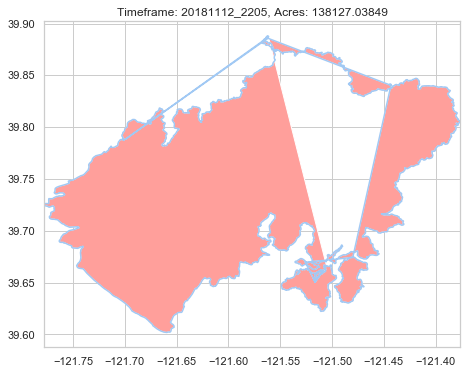

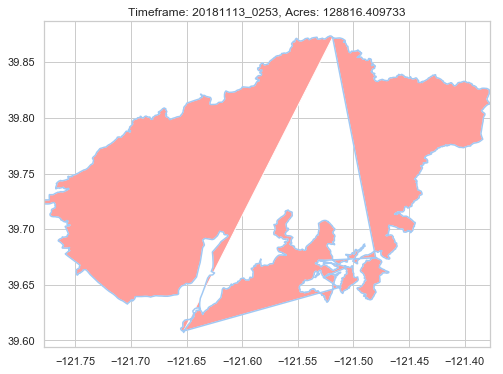

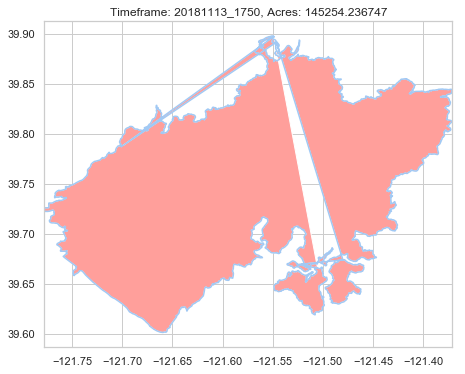

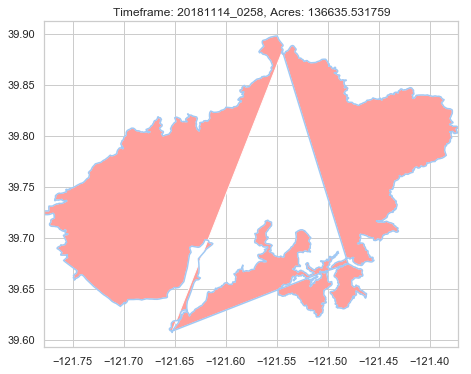

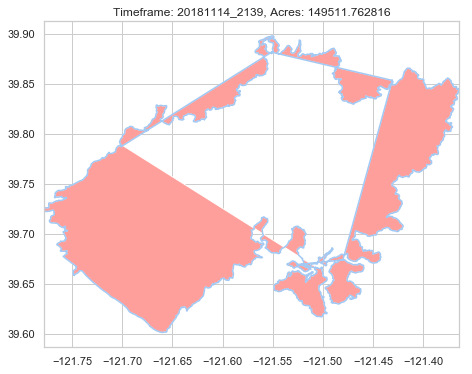

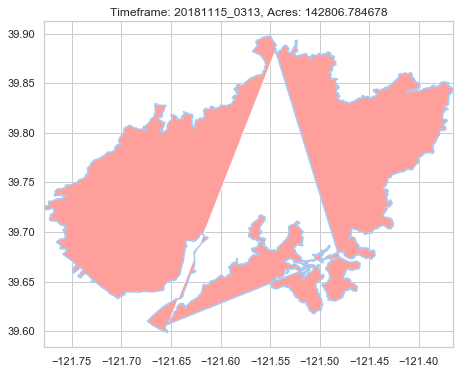

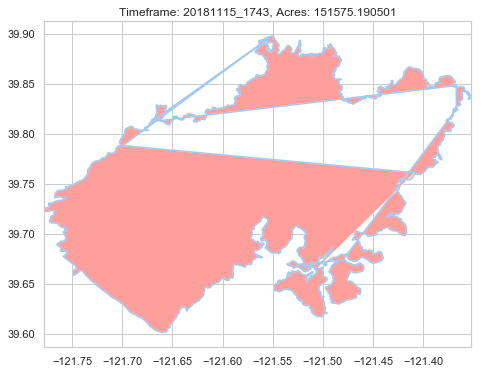

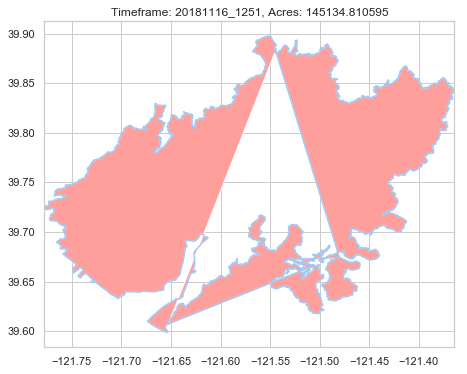

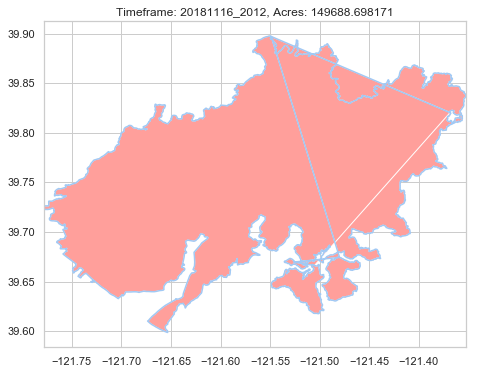

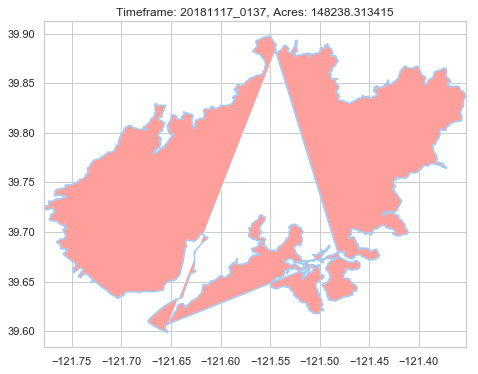

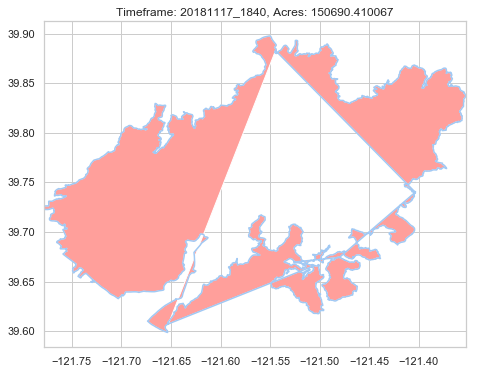

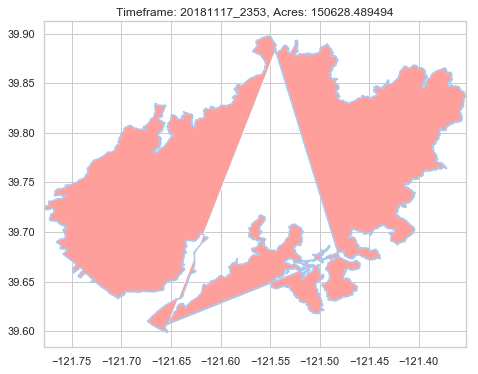

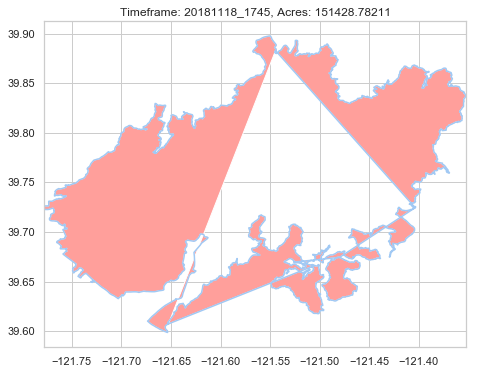

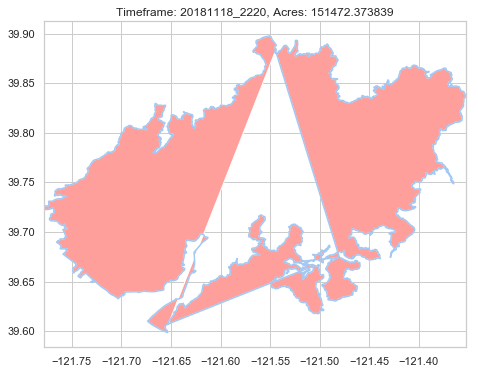

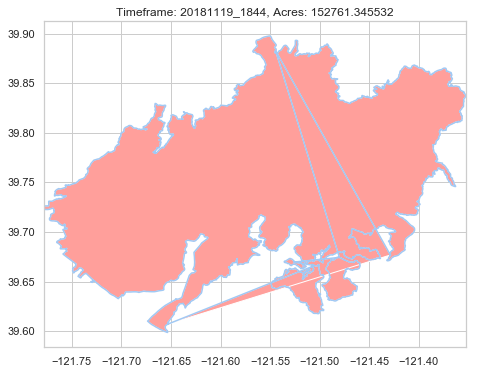

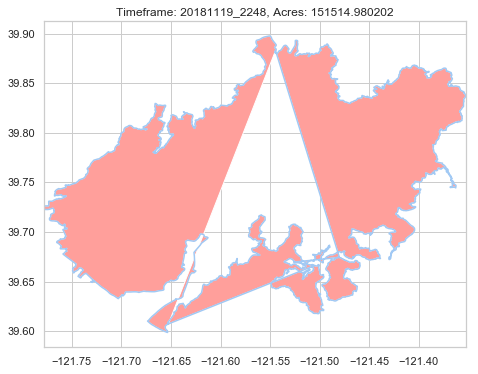

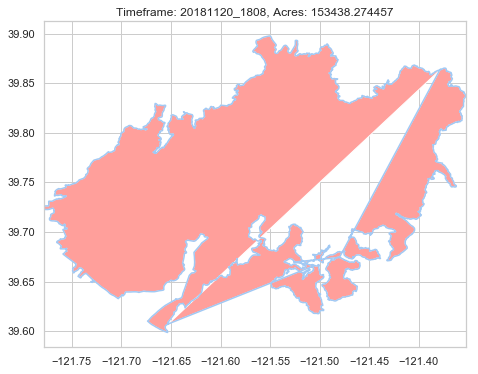

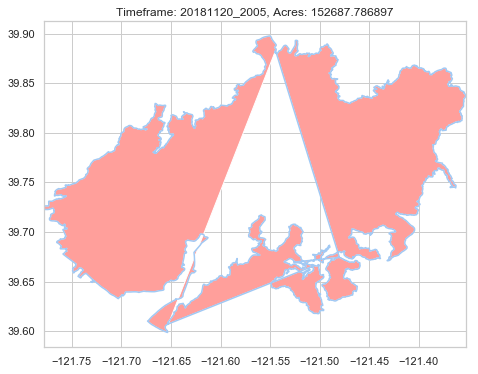

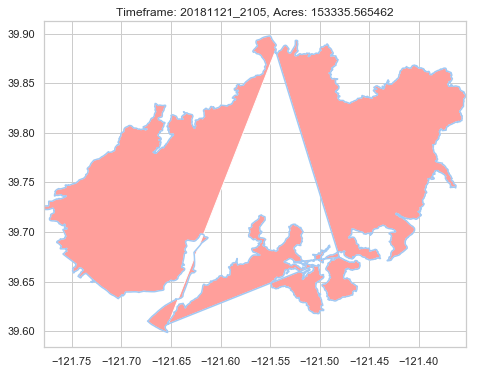

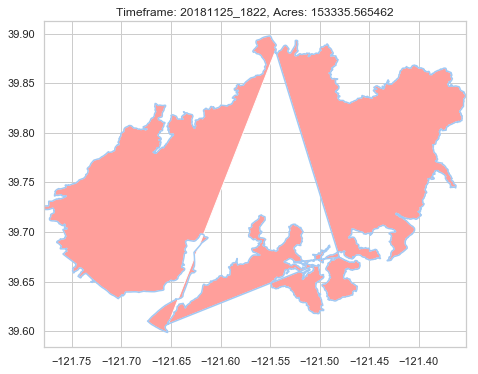

In [7]:
for shape_t in sorted_by_date:
    plot_shape(shape_t)


In [8]:
shape_t[2].columns

Index(['irwinid', 'mapmethod', 'unitIDProt', 'unitIDOwn', 'incidentID',
       'fireName', 'perDatTime', 'comments', 'agency', 'active', 'latest',
       'compParID', 'fireYear', 'dateCrnt', 'inciwebId', 'firecode', 'mergeid',
       'compfirecd', 'fireNum', 'ComplexNm', 'state', 'inComplex', 'GISACRES',
       'coords', 'file_nm'],
      dtype='object')

<h3> Print acreage data for each time frame

In [9]:
for shape_t in sorted_by_date:
    print(f'{shape_t[2]["perDatTime"]} acreage = {shape_t[2]["GISACRES"]}')

0    11/8/2018 5:54:00 PM
Name: perDatTime, dtype: object acreage = 0    54586.432795
Name: GISACRES, dtype: float64
0    11/9/2018
Name: perDatTime, dtype: object acreage = 0    70454.100342
Name: GISACRES, dtype: float64
0    11/9/2018 7:02:00 PM
Name: perDatTime, dtype: object acreage = 0    109502.882411
Name: GISACRES, dtype: float64
0    11/9/2018 11:13:00 PM
Name: perDatTime, dtype: object acreage = 0    108838.201625
Name: GISACRES, dtype: float64
0    11/10/2018 1:04:00 AM
Name: perDatTime, dtype: object acreage = 0    111552.361975
Name: GISACRES, dtype: float64
0    11/10/2018 9:10:00 PM
Name: perDatTime, dtype: object acreage = 0    114866.20788
Name: GISACRES, dtype: float64
0    11/11/2018 6:48:00 PM
Name: perDatTime, dtype: object acreage = 0    128799.057737
Name: GISACRES, dtype: float64
0    11/12/2018 12:31:00 AM
Name: perDatTime, dtype: object acreage = 0    130394.422837
Name: GISACRES, dtype: float64
0    11/12/2018 10:05:00 PM
Name: perDatTime, dtype: object acre

In [10]:
type(sorted_by_date[0][2].GISACRES)

pandas.core.series.Series

<h3>Plot with GeoPandas

This section uses GeoPandas to do explore the shape files. Here we are exploring the capabilities of the tools available. Next steps, given more time, would be to explore this further, and add the Basemap capability demonstrated in the reference implementation. There seems to be a lot of potential here both in terms of interacting with the data and rendering the images. Loading Basemap was unsuccessful for this project and more time would be needed to debug the environment issues. 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

In [42]:
#reload shapes, similar to above
gpd_shapes = []
gpd_shapes_df = pd.DataFrame() 

for i, shp_file_nm in enumerate(shp_files):
    df = gpd.read_file(shp_file_nm)
    df['file_nm'] = shp_file_nm[20:33]
    gpd_shapes_df = pd.concat([gpd_shapes_df,df])  
    gpd_shapes.append( (shp_file_nm[20:33],df) ) 

gpd_shapes_sorted = sorted(gpd_shapes, key=lambda tup: tup[0])


In [20]:
gpd_shapes_df.columns

Index(['ComplexNm', 'GISACRES', 'OBJECTID', 'SHAPE_Area', 'active', 'agency',
       'comments', 'compParID', 'compfirecd', 'dateCrnt', 'file_nm',
       'fireName', 'fireNum', 'fireYear', 'firecode', 'geometry', 'inComplex',
       'incidentID', 'inciwebId', 'irwinid', 'latest', 'mapmethod', 'mergeid',
       'perDatTime', 'state', 'unitIDOwn', 'unitIDProt'],
      dtype='object')

In [21]:
gpdf = gpd_shapes_sorted[0][1]
type(gpdf)

geopandas.geodataframe.GeoDataFrame

In [15]:
gpdf.head()

,irwinid,mapmethod,unitIDProt,unitIDOwn,incidentID,fireName,perDatTime,comments,agency,active,...,firecode,mergeid,compfirecd,fireNum,ComplexNm,state,inComplex,GISACRES,geometry,file_nm
0,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},Infrared Image,CABTU,CAPNF,2018-CABTU-016737,CAMP,11/8/2018 5:54:00 PM,Topology fixed,CDF,N,...,L6BH,None,None,016737,None,CA,N,54586.432795,(POLYGON ((-121.6149310952731 39.6602526071923...,20181108_1754


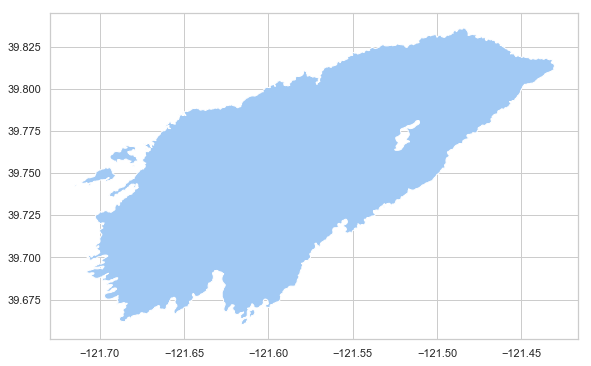

In [16]:
gpdf.plot();

In [22]:
gpd_shapes_df.shape

(28, 27)

In [23]:
gpd_shapes_df.head()

,ComplexNm,GISACRES,OBJECTID,SHAPE_Area,active,agency,comments,compParID,compfirecd,dateCrnt,...,incidentID,inciwebId,irwinid,latest,mapmethod,mergeid,perDatTime,state,unitIDOwn,unitIDProt
0,None,130394.422837,NaN,NaN,Y,CDF,None,None,None,2018-11-12,...,2018-CABTU-016737,None,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},Y,Mixed Methods,None,11/12/2018 12:31:00 AM,CA,CAPNF,CABTU
0,None,153335.565462,NaN,NaN,N,CDF,Final,None,None,2018-11-26,...,2018-CABTU-016737,6250,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},Y,Mixed Methods,None,11/25/2018 6:22:00 PM,CA,CAPNF,CABTU
0,None,142806.784678,NaN,NaN,N,CDF,None,None,None,2018-11-15,...,2018-CABTU-016737,6250,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},N,Mixed Methods,None,11/15/2018 3:13:00 AM,CA,CAPNF,CABTU
0,None,136635.531759,NaN,NaN,N,CDF,None,None,None,2018-11-14,...,2018-CABTU-016737,6250,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},N,Mixed Methods,None,11/14/2018 2:58:00 AM,CA,CAPNF,CABTU
0,None,54586.432795,NaN,NaN,N,CDF,Topology fixed,None,None,2018-11-09,...,2018-CABTU-016737,None,{75E64DB8-9B75-4A68-BEDD-67CC62658E38},N,Infrared Image,None,11/8/2018 5:54:00 PM,CA,CAPNF,CABTU


Beginning to explore color maps (cmap parameter)

In [24]:
gpd_shapes_df = gpd_shapes_df.sort_values(by='file_nm')

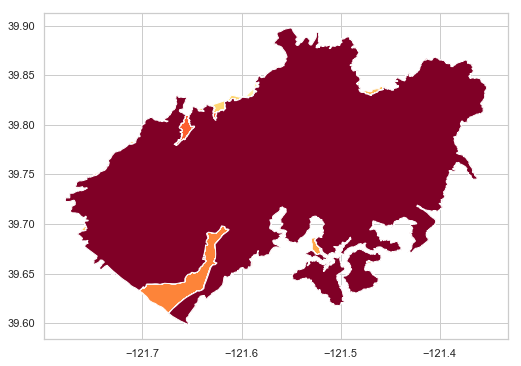

In [25]:
gpd_shapes_df.plot(cmap='YlOrRd');

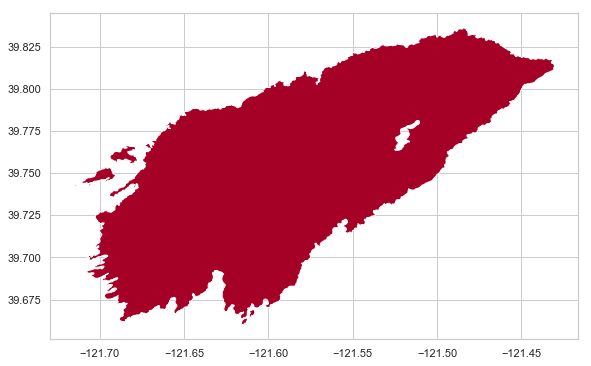

In [26]:
gpdf.plot(cmap='RdYlGn');